In [12]:
using TrajectoryOptimization
using Plots
using MeshCat
using GeometryTypes
using CoordinateTransformations
using FileIO
using LinearAlgebra
using Pkg

┌ Info: Precompiling FileIO [5789e2e9-d7fb-5bc7-8068-2c6fae9b9549]
└ @ Base loading.jl:1192


In [13]:
### Solver options ###
opts = SolverOptions()
opts.verbose = true;
opts.square_root = true;
opts.penalty_max = 1.0e8;
opts.outer_loop_update_type=:default;
#opts.outer_loop_update_type=:momentum; #makes very little difference
#opts.outer_loop_update_type=:accelerated; #makes a big difference but seems to overshoot and oscillate (do a linesearch?)
opts.iterations = 500;
opts.constraint_tolerance_intermediate = 1e-4;
opts.constraint_tolerance = 1e-4;

In [14]:
# Model
n = 13 # states (quadrotor w/ quaternions)
m = 4 # controls
model = Model(Dynamics.quadrotor_dynamics!,n,m)

TrajectoryOptimization.AnalyticalModel(TrajectoryOptimization.Dynamics.quadrotor_dynamics!, 13, 4)

In [15]:
# Objective and constraints
Qf = 100.0*Matrix{Float64}(I, n, n)
Q = (1.0)*Matrix{Float64}(I, n, n)
R = (0.1)*Matrix{Float64}(I, m, m)
tf = 5.0
dt = 0.05

# -initial state
x0 = zeros(n)
x0[4:7] = [1;0;0;0]

# -final state
xf = zeros(n)
xf[1:3] = [20.0;20.0;0.0] # xyz position
xf[4:7] = [1;0;0;0]
xf

# -control limits
u_min = -10.0
u_max = 10.0

# -obstacles
quad_radius = 3.0
sphere_radius = 1.0

n_spheres = 4
spheres = ([5.0;9.0;9.0;15.0;],[5.0;9.0;9.0;15.0],[0.0;0.0;4.0;0.0],[sphere_radius;sphere_radius;sphere_radius;sphere_radius])
function cI(x,u)
    [TrajectoryOptimization.sphere_constraint(x,spheres[1][1],spheres[2][1],spheres[3][1],spheres[4][1]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][2],spheres[2][2],spheres[3][2],spheres[4][2]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][3],spheres[2][3],spheres[3][3],spheres[4][3]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][4],spheres[2][4],spheres[3][4],spheres[4][4]+quad_radius);
     -x[3]]
end

# -constraint that quaternion should be unit
#function cE(x,u)
#    [x[4]^2 + x[5]^2 + x[6]^2 + x[7]^2 - 1.0]
#end

obj_uncon = LQRObjective(Q, R, Qf, tf, x0, xf);
obj_con = TrajectoryOptimization.ConstrainedObjective(obj_uncon, u_min=u_min, u_max=u_max);
#obj_con = TrajectoryOptimization.ConstrainedObjective(obj_uncon, u_min=u_min, u_max=u_max, cI=cI, cE = cE)

In [33]:
# Solver
solver_uncon = Solver(model,obj_uncon,integration=:rk3,dt=dt,opts=opts)
solver = Solver(model,obj_con,integration=:rk3,dt=dt,opts=opts)
solver_n = Solver(model, obj_con, integration=:rk3, dt=dt, opts=opts)
solver_n.opts.outer_loop_update_type = :default
solver_n.opts.use_nesterov = true

# - Initial control and state trajectories
U = (0.5*9.8/4.0).*ones(solver.model.m, solver.N); #Stationary Hover
# X_interp = line_trajectory(solver)

In [17]:
### Solve ###
results, stats = solve(solver,U);
#results, stats = solve(solver_uncon,U);

┌ Info: Solving Constrained Problem...
└ @ TrajectoryOptimization /home/bjack205/.julia/dev/TrajectoryOptimization/src/ilqr_methods.jl:267
┌ Info: Outer loop 1 (begin)
└ @ TrajectoryOptimization /home/bjack205/.julia/dev/TrajectoryOptimization/src/solve.jl:175
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    1     11099.599176  31351.4585              0.998449  0.5       10.00302  31302.83  0e+00     2.711799 1         Inf        0e+00    0          
    2     3157.0566334  7947.76264              0.999343  0.5       5.003836  7942.543  0e+00     4.988156 1         Inf        0e+00    0          
    3     753.21548663  2655.75339         

    26    510.99689258  0.02498619              0.263349  0.5       0.006313  0.00658   0e+00     0.003064 6         Inf        0e+00    0          
    27    510.99469344  0.01258023              0.174809  0.5       0.006291  0.002199  0e+00     0.002148 6         Inf        0e+00    0          
    28    510.99380634  0.00891201              0.09954   0.5       0.00629   0.000887  0e+00     0.001494 6         Inf        0e+00    0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
6         28   6           
┌ Info: Outer loop 7 (begin)
└ @ TrajectoryOptimization /home/bjack205/.julia/dev/TrajectoryOptimization/src/solve.jl:175
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____----------------------------------------------------------------

    64    744.72766767  6.82119204              0.835152  0.015625  0.001843  5.696731  0e+00     0.264958 9         Inf        0e+00    0          
    65    738.3326592   6.41463388              0.996941  0.015625  0.001812  6.395008  0e+00     0.394709 9         Inf        0e+00    0          
    66    733.14275144  6.14098364              0.845126  0.015625  0.001786  5.189908  0e+00     0.481581 9         Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    67    727.42660842  6.09876244              0.937263  0.015625  0.001757  5.716143  0e+00     0.262743 9         Inf        0e+00    0          
    68

    108   675.86438706  0.9412844               1.17116   0.003906  0.001472  1.102395  0e+00     0.568579 9         Inf        0e+00    0          
    109   674.7743929   0.93025069              1.171721  0.003906  0.001465  1.089994  0e+00     0.562691 9         Inf        0e+00    0          
    110   673.6967627   0.91930382              1.172224  0.003906  0.001459  1.07763   0e+00     0.556559 9         Inf        0e+00    0          
    111   672.63146785  0.90844453              1.172658  0.003906  0.001452  1.065295  0e+00     0.55028  9         Inf        0e+00    0          
    112   671.5784857   0.89767361              1.173012  0.003906  0.001446  1.052982  0e+00     0.543853 9         Inf        0e+00    0          
    113   670.5377976   0.88699188              1.173278  0.003906  0.001439  1.040688  0e+00     0.537265 9         Inf        0e+00    0          
    114   669.50938695  0.87640015              1.173449  0.003906  0.001433  1.028411  0e+00     0.53055 

    154   638.41547484  0.53272711              1.123446  0.003906  0.001222  0.59849   0e+00     0.352377 9         Inf        0e+00    0          
    155   637.825792    0.5258994               1.121284  0.003906  0.001218  0.589683  0e+00     0.349066 9         Inf        0e+00    0          
    156   637.24475876  0.51918093              1.119134  0.003906  0.001213  0.581033  0e+00     0.345899 9         Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    157   636.6722173   0.51257029              1.117001  0.003906  0.001209  0.572541  0e+00     0.34284  9         Inf        0e+00    0          
    15

    197   724.92704402  3.34202204              0.287089  0.007813  0.001041  0.959457  0e+00     0.457813 10        Inf        0e+00    0          
    198   723.96803528  3.64960432              0.262771  0.007813  0.001036  0.959009  0e+00     0.329159 10        Inf        0e+00    0          
    199   722.70908774  3.29131023              0.382506  0.007813  0.001031  1.258948  0e+00     0.365494 10        Inf        0e+00    0          
    200   721.57634462  3.19165809              0.354907  0.007813  0.001025  1.132743  0e+00     0.364845 10        Inf        0e+00    0          
    201   720.52716908  3.1817973               0.329743  0.007813  0.00102   1.049176  0e+00     0.371224 10        Inf        0e+00    0          
    202   719.68491314  3.21324642              0.26212   0.007813  0.001015  0.842256  0e+00     0.350577 10        Inf        0e+00    0          
    203   718.80623695  3.20576808              0.274092  0.007813  0.001011  0.878676  0e+00     0.354895

    242   701.80438801  2.96449252              0.080482  0.007813  0.000911  0.238588  0e+00     0.317718 10        Inf        0e+00    0          
    243   701.58161152  2.93353466              0.075941  0.007813  0.000909  0.222776  0e+00     0.321902 10        Inf        0e+00    0          
    244   701.3554763   2.95734852              0.076466  0.007813  0.000907  0.226135  0e+00     0.316516 10        Inf        0e+00    0          
    245   701.14746511  2.92644191              0.07108   0.007813  0.000906  0.208011  0e+00     0.32068  10        Inf        0e+00    0          
    246   700.93329866  2.95070103              0.072582  0.007813  0.000904  0.214166  0e+00     0.315399 10        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____----------------------------------------------------

    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    287   696.56633945  2.86213643              0.008387  0.007813  0.000849  0.024004  0e+00     0.292571 10        Inf        0e+00    0          
    288   696.51647129  2.89240204              0.017241  0.007813  0.000847  0.049868  0e+00     0.288894 10        Inf        0e+00    0          
    289   696.49682892  2.86163609              0.006864  0.007813  0.000847  0.019642  0e+00     0.29121  10        Inf        0e+00    0          
    290   696.45148738  2.89204179              0.015678  0.007813  0.000845  0.045342  0e+00     0.287608 10        Inf        0e+00    0          
    29

    328   680.21235271  0.77634522              0.370524  0.003906  0.000754  0.287654  0e+00     0.346312 10        Inf        0e+00    0          
    329   679.92741865  0.7766493               0.366876  0.003906  0.000753  0.284934  0e+00     0.329727 10        Inf        0e+00    0          
    330   679.64793904  0.77563301              0.360325  0.003906  0.000752  0.27948   0e+00     0.344486 10        Inf        0e+00    0          
    331   679.37013976  0.77429961              0.358775  0.003906  0.00075   0.277799  0e+00     0.32818  10        Inf        0e+00    0          
    332   679.09721088  0.77198093              0.353544  0.003906  0.000749  0.272929  0e+00     0.342783 10        Inf        0e+00    0          
    333   678.82545282  0.76980818              0.35302   0.003906  0.000748  0.271758  0e+00     0.326646 10        Inf        0e+00    0          
    334   678.5583417   0.76698156              0.348263  0.003906  0.000746  0.267111  0e+00     0.341285

    370   737.77409288  1.92243237              0.146839  0.003906  0.000707  0.282288  0e+00     0.404175 11        Inf        0e+00    0          
    371   737.47209229  1.93195776              0.156318  0.003906  0.000706  0.302001  0e+00     0.389122 11        Inf        0e+00    0          
    372   737.1953877   1.91818294              0.144253  0.003906  0.000705  0.276705  0e+00     0.402558 11        Inf        0e+00    0          
    373   736.89905754  1.92792012              0.153705  0.003906  0.000704  0.29633   0e+00     0.387638 11        Inf        0e+00    0          
    374   736.62781533  1.91410589              0.141707  0.003906  0.000703  0.271242  0e+00     0.401122 11        Inf        0e+00    0          
    375   736.33703541  1.92404186              0.15113   0.003906  0.000702  0.29078   0e+00     0.386299 11        Inf        0e+00    0          
    376   736.07113099  1.91017589              0.139204  0.003906  0.000701  0.265904  0e+00     0.399741

    414   727.24110418  1.85089052              0.100817  0.003906  0.000672  0.186601  0e+00     0.38003  11        Inf        0e+00    0          
    415   727.0370198   1.86364884              0.109508  0.003906  0.000671  0.204084  0e+00     0.36782  11        Inf        0e+00    0          
    416   726.85364316  1.84832362              0.099212  0.003906  0.000671  0.183377  0e+00     0.379301 11        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    417   726.65290321  1.86119204              0.107856  0.003906  0.00067   0.20074   0e+00     0.36719  11        Inf        0e+00    0          
    41

    457   720.14877611  1.81966922              0.08083   0.003906  0.000648  0.147083  0e+00     0.356872 11        Inf        0e+00    0          
    458   720.01884137  1.8031712               0.072059  0.003906  0.000648  0.129935  0e+00     0.366834 11        Inf        0e+00    0          
    459   719.87389958  1.81791763              0.07973   0.003906  0.000647  0.144942  0e+00     0.356196 11        Inf        0e+00    0          
    460   719.74596124  1.80137372              0.071023  0.003906  0.000647  0.127938  0e+00     0.366108 11        Inf        0e+00    0          
    461   719.60312033  1.81619265              0.078649  0.003906  0.000646  0.142841  0e+00     0.355536 11        Inf        0e+00    0          
    462   719.47713719  1.79960383              0.070006  0.003906  0.000646  0.125983  0e+00     0.365398 11        Inf        0e+00    0          
    463   719.33635453  1.8144928               0.077588  0.003906  0.000645  0.140783  0e+00     0.35489 

    500   762.20745937  3.20816559              0.142222  0.003906  0.000627  0.456271  0e+00     0.440565 12        Inf        0e+00    0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
12        500  4           
┌ Info: ***Solve Complete***
└ @ TrajectoryOptimization /home/bjack205/.julia/dev/TrajectoryOptimization/src/solve.jl:376


In [34]:
results_n, stats_n = solve(solver_n,U);

┌ Info: Solving Constrained Problem...
└ @ TrajectoryOptimization /home/bjack205/.julia/dev/TrajectoryOptimization/src/ilqr_methods.jl:267
┌ Info: Outer loop 1 (begin)
└ @ TrajectoryOptimization /home/bjack205/.julia/dev/TrajectoryOptimization/src/solve.jl:175
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    1     11099.599176  31351.4585              0.998449  0.5       10.00302  31302.83  0e+00     2.711799 1         Inf        0e+00    0          
    2     3157.0566334  7947.76264              0.999343  0.5       5.003836  7942.543  0e+00     4.988156 1         Inf        0e+00    0          
    3     753.21548663  2655.75339         

    28    510.63388539  0.00308154              0.219624  0.5       0.006416  0.000677  0e+00     0.001191 6         Inf        0e+00    0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
6         28   6           
┌ Info: Outer loop 7 (begin)
└ @ TrajectoryOptimization /home/bjack205/.julia/dev/TrajectoryOptimization/src/solve.jl:175
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    29    521.46682261  11.6390671              0.803237  0.5       0.004164  9.348924  0e+00     0.077663 7         Inf        0e+00    0          
    30    520.6604

    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    66    740.09436765  0.00037885              1.000001  9.54e-07  0.002016  0.000379  0e+00     0.498165 9         Inf        0e+00    0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
9         66   1           
┌ Info: Outer loop 10 (begin)
└ @ TrajectoryOptimization /home/bjack205/.julia/dev/TrajectoryOptimization/src/solve.jl:175
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info              

    106   732.29588612  1.43514053              1.179503  0.003906  0.00145   1.692752  0e+00     0.817668 10        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    107   730.62043603  1.41725595              1.182179  0.003906  0.001441  1.67545   0e+00     0.811149 10        Inf        0e+00    0          
    108   728.96212956  1.39946445              1.184958  0.003906  0.001433  1.658306  0e+00     0.804356 10        Inf        0e+00    0          
    109   727.32086704  1.3817652               1.187801  0.003906  0.001425  1.641263  0e+00     0.797186 10        Inf        0e+00    0          
    11

    149   679.74835237  0.81730411              1.035667  0.003906  0.001169  0.846454  0e+00     0.41444  10        Inf        0e+00    0          
    150   678.91453601  0.80588467              1.03466   0.003906  0.001164  0.833816  0e+00     0.412096 10        Inf        0e+00    0          
    151   678.09316715  0.79467493              1.033591  0.003906  0.001159  0.821369  0e+00     0.407417 10        Inf        0e+00    0          
    152   677.28404076  0.78366348              1.032492  0.003906  0.001154  0.809126  0e+00     0.405352 10        Inf        0e+00    0          
    153   676.48696034  0.77286091              1.031337  0.003906  0.001149  0.79708   0e+00     0.401065 10        Inf        0e+00    0          
    154   675.70171753  0.76225669              1.030155  0.003906  0.001145  0.785243  0e+00     0.399231 10        Inf        0e+00    0          
    155   674.9281114   0.75185773              1.028926  0.003906  0.00114   0.773606  0e+00     0.395343

    195   652.64392015  1.51251662              0.249541  0.007813  0.001001  0.377435  0e+00     0.278245 10        Inf        0e+00    0          
    196   652.27707396  1.50268947              0.244126  0.007813  0.000999  0.366846  0e+00     0.289887 10        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    197   651.91237854  1.5008938               0.242985  0.007813  0.000996  0.364695  0e+00     0.276666 10        Inf        0e+00    0          
    198   651.55836666  1.4910046               0.237432  0.007813  0.000994  0.354012  0e+00     0.288205 10        Inf        0e+00    0          
    19

    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    237   747.7876432   0.00230749              1.000077  7.63e-06  0.00086   0.002308  0e+00     0.534747 11        Inf        0e+00    0          
    238   747.78648953  0.00115363              1.000038  3.81e-06  0.00086   0.001154  0e+00     0.534658 11        Inf        0e+00    0          
    239   747.78620113  0.00028839              1.000009  9.54e-07  0.00086   0.000288  0e+00     0.534613 11        Inf        0e+00    0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
11        239  23  

    267   818.52304767  3.78728069              0.162527  0.003906  0.000811  0.615534  0e+00     0.595418 14        Inf        0e+00    0          
    268   817.96945619  3.85590547              0.14357   0.003906  0.000809  0.553591  0e+00     0.559922 14        Inf        0e+00    0          
    269   817.37907934  3.77833779              0.156253  0.003906  0.000807  0.590377  0e+00     0.592519 14        Inf        0e+00    0          
    270   816.84270824  3.85243873              0.139229  0.003906  0.000805  0.536371  0e+00     0.556692 14        Inf        0e+00    0          
    271   816.27617795  3.76933986              0.1503    0.003906  0.000804  0.56653   0e+00     0.589835 14        Inf        0e+00    0          
    272   815.75602512  3.84863954              0.135152  0.003906  0.000802  0.520153  0e+00     0.553737 14        Inf        0e+00    0          
    273   815.21235519  3.76039056              0.144578  0.003906  0.0008    0.54367   0e+00     0.587347

    312   800.45468578  3.82429949              0.091649  0.003906  0.00074   0.350494  0e+00     0.50143  14        Inf        0e+00    0          
    313   800.28719861  3.58434157              0.046727  0.003906  0.00074   0.167487  0e+00     0.547933 14        Inf        0e+00    0          
    314   799.93750328  3.8270239               0.091375  0.003906  0.000738  0.349695  0e+00     0.499319 14        Inf        0e+00    0          
    315   799.78774112  3.57392478              0.041904  0.003906  0.000737  0.149762  0e+00     0.547122 14        Inf        0e+00    0          
    316   799.43802959  3.83018504              0.091304  0.003906  0.000736  0.349712  0e+00     0.49723  14        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____----------------------------------------------------

    356   766.26841028  1.154569                0.372259  0.003906  0.000625  0.429799  0e+00     0.498009 14        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    357   765.75628684  1.33820564              0.382694  0.001953  0.000623  0.512123  0e+00     0.494792 14        Inf        0e+00    0          
    358   765.39993994  0.7098615               0.501995  0.001953  0.000622  0.356347  0e+00     0.517776 14        Inf        0e+00    0          
    359   765.04608855  0.7121657               0.496867  0.001953  0.000621  0.353851  0e+00     0.49768  14        Inf        0e+00    0          
    36

    398   798.7662509   1.49190921              0.153139  0.001953  0.000587  0.22847   0e+00     0.606304 15        Inf        0e+00    0          
    399   798.49462294  1.64770126              0.164853  0.001953  0.000586  0.271628  0e+00     0.576986 15        Inf        0e+00    0          
    400   798.22399955  1.6116235               0.16792   0.001953  0.000585  0.270623  0e+00     0.602573 15        Inf        0e+00    0          
    401   797.94908363  1.59608676              0.172244  0.001953  0.000585  0.274916  0e+00     0.578296 15        Inf        0e+00    0          
    402   797.6781372   1.57933693              0.171557  0.001953  0.000584  0.270946  0e+00     0.604414 15        Inf        0e+00    0          
    403   797.40432626  1.57612148              0.173725  0.001953  0.000583  0.273811  0e+00     0.577982 15        Inf        0e+00    0          
    404   797.13528848  1.56633403              0.171763  0.001953  0.000583  0.269038  0e+00     0.604199

    442   788.04557454  1.52891375              0.136786  0.001953  0.000558  0.209134  0e+00     0.573872 15        Inf        0e+00    0          
    443   787.83463842  1.53347007              0.137555  0.001953  0.000557  0.210936  0e+00     0.546522 15        Inf        0e+00    0          
    444   787.62824725  1.52779693              0.135091  0.001953  0.000557  0.206391  0e+00     0.571672 15        Inf        0e+00    0          
    445   787.42004162  1.5324005               0.135869  0.001953  0.000556  0.208206  0e+00     0.544386 15        Inf        0e+00    0          
    446   787.21634563  1.52669758              0.133423  0.001953  0.000556  0.203696  0e+00     0.569528 15        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____----------------------------------------------------

    486   779.98637431  1.50767488              0.105043  0.001953  0.000536  0.15837   0e+00     0.536568 15        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    487   779.82590521  1.51313319              0.106051  0.001953  0.000535  0.160469  0e+00     0.510126 15        Inf        0e+00    0          
    488   779.66943116  1.50684858              0.103842  0.001953  0.000535  0.156474  0e+00     0.535257 15        Inf        0e+00    0          
    489   779.51084428  1.51234303              0.104862  0.001953  0.000534  0.158587  0e+00     0.50885  15        Inf        0e+00    0          
    49

In [18]:
### Results ###
println("Final position: $(results.X[end][1:3])\n       desired: $(obj_uncon.xf[1:3])\n    Iterations: $(stats["iterations"])\n Max violation: $(max_violation(results))")

Final position: [20.0, 20.0, -4.68406e-5]
       desired: [20.0, 20.0, 0.0]
    Iterations: 500
 Max violation: 0.0006271003185481794


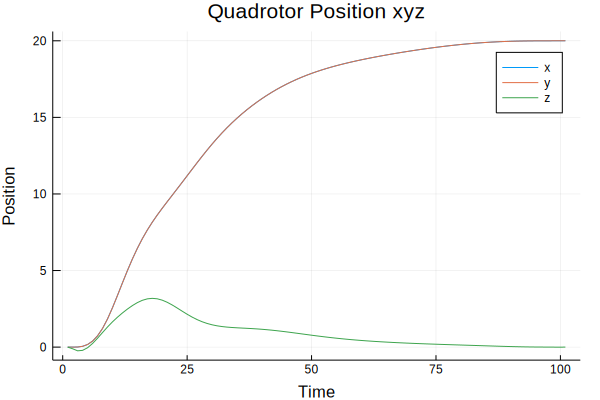

In [20]:
# Position
xhist = hcat(results.X...)
plot(xhist[1:3,:]',title="Quadrotor Position xyz",xlabel="Time",ylabel="Position",label=["x";"y";"z"])

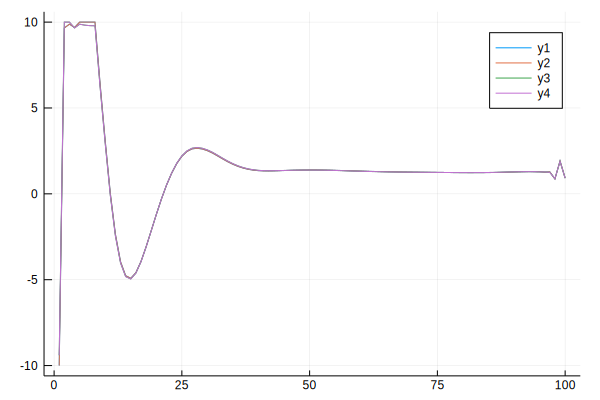

In [21]:
# Control
uhist = hcat(results.U...)
plot(uhist')

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /home/bjack205/.julia/packages/Plots/qh1wV/src/args.jl:1169


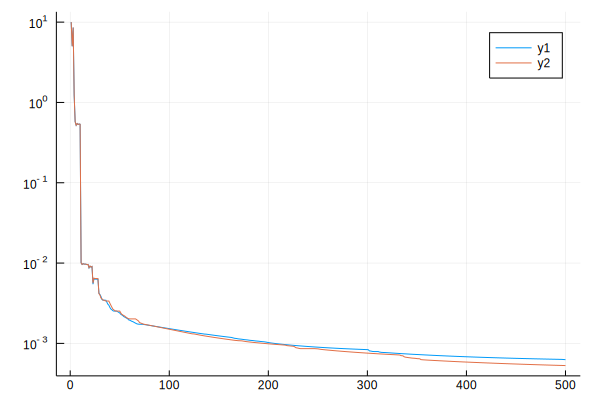

In [35]:
# Convergence
plot(stats["c_max"],yscale=:log)
plot!(stats_n["c_max"])

Quaternion Animation

In [22]:
### Visualizer using MeshCat and GeometryTypes ###
# Set up visualizer
vis = Visualizer()
open(vis)

# Import quadrotor obj file
urdf_folder = joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf")
# urdf = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor.urdf")
obj = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor_base.obj")

# color options
green = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
red = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
blue = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
orange = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
black = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))

# geometries
robot_obj = load(obj)
sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.03*quad_radius)) # trajectory points
sphere_medium = HyperSphere(Point3f0(0), convert(Float32,quad_radius))

#obstacles = vis["obs"]
traj = vis["traj"]
target = vis["target"]
robot = vis["robot"]

# Set camera location
settransform!(vis["/Cameras/default"], compose(Translation(25., -5., 10),LinearMap(RotZ(-pi/4))))

# Create and place obstacles
#for i = 1:n_spheres
#    setobject!(vis["obs"]["s$i"],HyperSphere(Point3f0(0), convert(Float32,spheres[4][i])),red)
#    settransform!(vis["obs"]["s$i"], Translation(spheres[1][i], spheres[2][i], spheres[3][i]))
#end

# Create and place trajectory
for i = 1:solver.N
    setobject!(vis["traj"]["t$i"],sphere_small,blue)
    settransform!(vis["traj"]["t$i"], Translation(xhist[1,i], xhist[2,i], xhist[3,i]))
end

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8700
└ @ MeshCat /home/bjack205/.julia/packages/MeshCat/jt9Xz/src/servers.jl:7
┌ Info: Listening on: Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 0x21fc)
└ @ HTTP.Servers /home/bjack205/.julia/packages/HTTP/YjRCz/src/Servers.jl:301
┌ Warning: `Pkg.dir(pkgname, paths...)` is deprecated; instead, do `import TrajectoryOptimization; joinpath(dirname(pathof(TrajectoryOptimization)), "..", paths...)`.
└ @ Pkg.API /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Pkg/src/API.jl:480
Error encountered while loading "/home/bjack205/.julia/dev/TrajectoryOptimization/dynamics/urdf/quadrotor_base.obj".

Opening in existing browser session.



┌ Info: Accept (0):  🔗    0↑     0↓    1s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/bjack205/.julia/packages/HTTP/YjRCz/src/Servers.jl:343
Fatal error:┌ Info: Accept (1):  🔗    0↑     0↓    1s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/bjack205/.julia/packages/HTTP/YjRCz/src/Servers.jl:343



ArgumentError: ArgumentError: Package MeshIO not found in current path:
- Run `import Pkg; Pkg.add("MeshIO")` to install the MeshIO package.


┌ Info: Closed (1):  💀    0↑     0↓🔒   5s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/bjack205/.julia/packages/HTTP/YjRCz/src/Servers.jl:351
┌ Info: Accept (2):  🔗    0↑     0↓    0s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/bjack205/.julia/packages/HTTP/YjRCz/src/Servers.jl:343
┌ Info: Accept (3):  🔗    0↑     0↓    0s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/bjack205/.julia/packages/HTTP/YjRCz/src/Servers.jl:343
┌ Info: Accept (4):  🔗    0↑     0↓    0s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/bjack205/.julia/packages/HTTP/YjRCz/src/Servers.jl:343
Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")┌ Info: Closed (4):  💀    1↑     1↓🔒   4s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/bjack205/.julia/packages/HTTP/YjRCz/src/Servers.jl:351


In [ ]:
# Create and place initial position
setobject!(vis["robot"]["ball"],sphere_medium,black_transparent)
setobject!(vis["robot"]["quad"],robot_obj,black)
settransform!(vis["robot"],compose(Translation(xhist[1,1], xhist[2,1], xhist[3,1]),LinearMap(TrajectoryOptimization.quat2rot(xhist[4:7,1]))))

In [ ]:
# Animate quadrotor
for i = 1:solver.N
    settransform!(vis["robot"], compose(Translation(xhist[1,i], xhist[2,i], xhist[3,i]),LinearMap(TrajectoryOptimization.quat2rot(xhist[4:7,i]))))
    sleep(solver.dt)
end

# # -unconstrained version
# for i = 1:solver.N
#     settransform!(vis["robot"], compose(Translation(results_uncon.X[1,i], results_uncon_euler.X[2,i], results_uncon.X[3,i]),LinearMap(TrajectoryOptimization.quat2rot(results_uncon.X[4:7,i]))))
#     sleep(solver.dt*2)
# end
